# Import Library

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import kurtosis, skew
from yellowbrick.target import FeatureCorrelation,ClassBalance
import swifter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.special import boxcox1p
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 기호도 표시
from matplotlib import font_manager, rc

## 한글 깨짐 방지 목적 
font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

## For Mac
# rc('font', family='/Library/Fonts/AppleGothic.ttf')

import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Import data

In [2]:
train = pd.read_csv('merged_train.csv')
test = pd.read_csv('test.csv')

train data의 data type을 살펴 보았습니다. 'date'는 datetime형태의 데이터 타입이어야 하는데 'object'임이 확인되었습니다. 데이터 타입을 적절하게 변형시킵니다.

In [3]:
train = train.iloc[:,1:]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224439 entries, 0 to 1224438
Data columns (total 17 columns):
date                  1224439 non-null object
date_block_num        1224439 non-null int64
shop_id               1224439 non-null int64
item_id               1224439 non-null int64
item_price            1224439 non-null float64
item_cnt_day          1224439 non-null float64
year                  1224439 non-null int64
year_month            1224439 non-null object
month                 1224439 non-null int64
quarter               1224439 non-null int64
weekday               1224439 non-null int64
weekday_name          1224439 non-null object
day                   1224439 non-null int64
item_name             1224439 non-null object
item_category_id      1224439 non-null int64
item_category_name    1224439 non-null object
shop_name             1224439 non-null object
dtypes: float64(2), int64(9), object(6)
memory usage: 158.8+ MB


In [4]:
def add_time_features(data,x):
    data[x] = pd.to_datetime(data[x],format = '%Y-%m-%d')
    data['year'] = data[x].dt.year
    data['year_month'] = data[x].dt.to_period('M')
    data['month'] = data[x].dt.month
    data['quarter'] = data[x].dt.quarter
    data['weekday'] = data[x].dt.weekday
    data['weekday_name'] = data[x].dt.weekday_name
    data['day'] = data[x].dt.day
    return data

train = add_time_features(train,'date')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224439 entries, 0 to 1224438
Data columns (total 17 columns):
date                  1224439 non-null datetime64[ns]
date_block_num        1224439 non-null int64
shop_id               1224439 non-null int64
item_id               1224439 non-null int64
item_price            1224439 non-null float64
item_cnt_day          1224439 non-null float64
year                  1224439 non-null int64
year_month            1224439 non-null period[M]
month                 1224439 non-null int64
quarter               1224439 non-null int64
weekday               1224439 non-null int64
weekday_name          1224439 non-null object
day                   1224439 non-null int64
item_name             1224439 non-null object
item_category_id      1224439 non-null int64
item_category_name    1224439 non-null object
shop_name             1224439 non-null object
dtypes: datetime64[ns](1), float64(2), int64(9), object(4), period[M](1)
memory usage: 158.8+ MB


같은 날('Date') 같은 상품('Item_name')을 각 상점에서 팔 때 가격이 다름을 확인할 수 있습니다.

In [5]:
## Method 1 ##
# c1 = []
# c2 = []
# for i in np.unique(train['item_name']):
#     bo = train[train['item_name'] == i]
#     for j in np.unique(bo['date']):
#         bo2 = bo[bo['date'] == j]
#         if len(np.unique(bo2['item_price'])) == 1:
#             c1.append([i,j])
#         else:
#             c2.append([i,j])

## Method 2 ##
plate = []
for a,b in train.groupby(['item_name','date']):
    if len(np.unique(b['item_price'])) == 1:
        continue
    else:
        plate.append([a,np.unique(b['item_price'])])

In [6]:
len(plate)

36139

새로운 테이블('easy_ta')를 구성한 후 'date','item_name'기준으로 가격의 차이를 정량화한 'price_gap'과 'price_gap'을 Scaling한 'normalized_price_gap'을 생성합니다.

In [7]:
a1 = [plate[i][0][0] for i in range(len(plate))]
a2 = [plate[i][0][1] for i in range(len(plate))]
a3 = [plate[i][1] for i in range(len(plate))]

easy_ta = pd.DataFrame({'item_name' : a1,
                        'date' : a2,
                        'price' : a3})

In [8]:
easy_ta['price_gap'] = easy_ta['price'].apply(lambda x : x.max() - x.min())
easy_ta['normalized_price_gap'] = (easy_ta['price_gap'] - easy_ta['price_gap'].mean()) / easy_ta['price_gap'].std()

In [9]:
easy_ta.head()

,item_name,date,price,price_gap,normalized_price_gap
0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,2013-02-12,"[359.0, 379.0, 394.555555556, 399.0]",40.0,-0.368564
1,007: КООРДИНАТЫ «СКАЙФОЛЛ»,2013-02-13,"[359.0, 372.33333333300004, 379.0, 387.5714285...",40.0,-0.368564
2,007: КООРДИНАТЫ «СКАЙФОЛЛ»,2013-02-14,"[265.0, 379.0, 389.0, 391.0, 399.0]",134.0,-0.188875
3,007: КООРДИНАТЫ «СКАЙФОЛЛ»,2013-02-15,"[359.0, 385.66666666699996, 391.0, 398.9285714...",40.0,-0.368564
4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,2013-02-16,"[265.0, 379.0, 385.66666666699996, 389.0, 392....",134.0,-0.188875


상품의 변동성이 높은 상위 품목은 다음과 같습니다.

- Прием денежных средств для 1С-Онлайн
- Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...
- Xbox One 500 ГБ + Assassins Creed Единство + A...
- Комплект "Microsoft Xbox One 1TB  (CoD:AW) + "...
- Комплект "Microsoft Xbox One 500GB (Day One Ed...
- Комплект "Microsoft Xbox One 500GB" + "Ведьмак...
- Sony PlayStation 4 (1Tb) Black (CUH-1208B)
- Комплект "Microsoft Xbox 360 E 500GB"+Kinect+ ...
- Комплект "Microsoft Xbox One 1TB  Limited Edit...
- Комплект "Microsoft Xbox 360 E 500GB" + "Call ...
- Sony PlayStation 4 (500 Gb) Black (CUH-1208A/B01)
- Grand Theft Auto V [PS4, русские субтитры]
- Titanfall [Xbox 360, русская версия]
- Battlefield 4 [PS3, русская версия]
- PS4: Гарнитура беспроводная черная для PS4 (с ...
</bs>

상품의 변동성이 낮은 하위 품목은 다음과 같습니다.

- Метро 2033. Возвращение [Xbox One, русская вер...
- RICHARDS KEITH  Crosseyed Heart
- Мини-головоломка 9**/ Mini Wire 09** Арт. 473309
- REA CHRIS The Very Best Of
- RAMMSTEIN  Sehnsucht
- Микроробот Нано Mouse Cat Toy
- RAMMSTEIN  Live Aus Berlin
- QUEEN  Innuendo  2LP
- Мини-головоломка 11***/ Mini Wire 11*** Арт. 4...
- Мини-головоломка 12**/ Mini Wire 12** Арт. 473312
- Мини-головоломка 13**/ Mini Wire 13** Арт. 473313
- Мини-головоломка 2**/ Mini Wire 02** Арт. 473328
- Мини-головоломка 23**/ Mini Wire 23** Арт. 473323
- Мини-головоломка 3**/ Mini Wire 03** Арт. 473303
- PRESLEY ELVIS  The Greatest  3CD

In [10]:
top = [easy_ta[easy_ta['item_name'] == i] for i in np.unique(easy_ta['item_name'])] 

In [11]:
p = []
for i in range(len(top)):
    a1 = top[i].max()
    a2 = top[i].min()
    p.append(a1)
    p.append(a2)
min_max_gap = pd.DataFrame(p)

In [12]:
max_v = min_max_gap.groupby(['item_name'])['price_gap'].max().reset_index() 
min_v = min_max_gap.groupby(['item_name'])['price_gap'].min().reset_index()
w = max_v['price_gap'] - min_v['price_gap']
max_v['w'] = w
max_v = max_v.sort_values(by = 'w',ascending=False)
print(max_v[:15]['item_name'])
print()
print(max_v[-15:]['item_name'])

2010                 Прием денежных средств для 1С-Онлайн
812     Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...
939     Xbox One 500 ГБ + Assassins Creed Единство + A...
1484    Комплект "Microsoft Xbox One 1TB  (CoD:AW) + "...
1486    Комплект "Microsoft Xbox One 500GB (Day One Ed...
1487    Комплект "Microsoft Xbox One 500GB" + "Ведьмак...
811            Sony PlayStation 4 (1Tb) Black (CUH-1208B)
1483    Комплект "Microsoft Xbox 360 E 500GB"+Kinect+ ...
1485    Комплект "Microsoft Xbox One 1TB  Limited Edit...
1482    Комплект "Microsoft Xbox 360 E 500GB" + "Call ...
813     Sony PlayStation 4 (500 Gb) Black (CUH-1208A/B01)
425            Grand Theft Auto V [PS4, русские субтитры]
844                  Titanfall [Xbox 360, русская версия]
143                   Battlefield 4 [PS3, русская версия]
673     PS4: Гарнитура беспроводная черная для PS4 (с ...
Name: item_name, dtype: object

1659    Метро 2033. Возвращение [Xbox One, русская вер...
729                       RICHARDS KEITH

각 아이템별 가격 차이에 대한 분포를 살펴보면 다음과 같습니다.

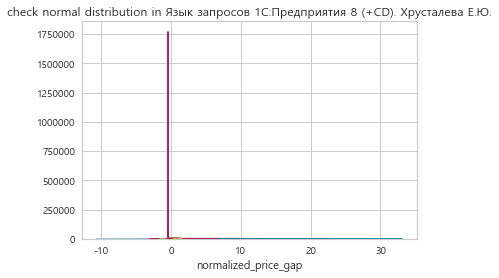

In [13]:
for i in np.unique(easy_ta['item_name']):
    part1 = easy_ta[easy_ta['item_name'] == i]
    sns.distplot(part1['normalized_price_gap'])
    plt.title('check normal distribution ' + 'in ' + i)
   # qqplot(part1['normalized_price_gap'],line = 's')

# Question 2 : 'Item_cnt_day'와 'item_price'는 어떤 관계를 가지는가?

train set을 상점명을 기준으로 총 42개의 subset으로 나눕니다. 이 때 'date'를 기준으로 sorting합니다.

In [14]:
len(np.unique(train['shop_name']))

42

In [15]:
train_shop = [train[train['shop_name'] == i].sort_values(by = ['date'],ascending = True) for i in np.unique(train['shop_name'])]

각 상점의 'item_price'와 'item_cnt_day'간의 상관관계를 살펴보면 'item_price'가 낮을 수록 'item_cnt_day'가 높아지는 경향을 발견하였습니다.

In [16]:
def scatter_plot(data,cri1,cri2):
    sa = data[cri1]
    sa2 = data[cri2]

    trace = go.Scatter(
        x = sa,
        y = sa2,
        mode = 'markers')

    layout = go.Layout(title = 'Relationship between ' +  cri1 + ' and ' + cri2,
                  yaxis = dict(
                      title = cri2,
                      zeroline = False),
                  xaxis = dict(
                      title = cri1,
                      zeroline = False))

    data = [trace]
    fig = dict(data = data, layout = layout)
    iplot(fig)

In [17]:
# for i in range(0,5,1):
#     scatter_plot(train_shop[i],'item_price','item_cnt_day')

# Question 3 : 각 상점의 'item_cnt_day'와 'item_price'에 대한 Seasonality와 Trend가 존재하는가?

우리가 머신러닝 모델을 만들려는 목적을 다시 한번 상기하면 다음과 같습니다.
- train set(2013-01~2015-10)을 통해 Test set(2015-11)의 각 상점에 따른 상품들의 판매량을 예측하는 것이 문제입니다.
- 해당 데이터는 시계열 데이터입니다.
- Train set과 Test set의 'item_cnt_day'의 합을 한달 단위로 접근한다면(Downsampling) 우리는 다음과 같은 문제에 봉착합니다.
    - 1) Train data set에서 학습할 수 있는 양(관측치 : 34)이 작아집니다.
    - 2) Downsampling 기법상 정보의 손실이 발생합니다.
- Train set과 Test set의 'item_cnt_day'를 한 시간 단위로 접근한다면(Upsampling) 극단적으로 관측치의 양을 늘릴 수 있지만 정보에 대한 신뢰성에 의문이 제기됩니다.

In [18]:
p1 = []
p2 = []

for i in np.unique(train['shop_name']):
    df1 = train[train['shop_name'] == i]
    for j in np.unique(df1['item_id']):
        df2 = df1[df1['item_id'] == j]
        df3 = df2.groupby(['year_month'])['item_cnt_day'].sum().reset_index()
        df3['shop_name'] = i
        df3['item_id'] = j
        df4 = df2.groupby(['year_month','weekday'])['item_cnt_day'].sum().reset_index()
        df4['shop_name'] = i
        df4['item_id'] = j
        p1.append(df3)
        p2.append(df4)

month_sum = pd.concat(p1[0:])
week_sum = pd.concat(p2[0:])

In [19]:
month_sum.head()

,year_month,item_cnt_day,shop_name,item_id
0,2013-03,1.0,"Адыгея ТЦ ""Мега""",30
1,2013-06,1.0,"Адыгея ТЦ ""Мега""",30
2,2014-04,1.0,"Адыгея ТЦ ""Мега""",30
3,2014-05,1.0,"Адыгея ТЦ ""Мега""",30
0,2013-02,4.0,"Адыгея ТЦ ""Мега""",31


In [20]:
len(np.unique(month_sum['shop_name']))

42

월을 기준으로 27.8%가 단일한 값을 가집니다. 즉 상점과 아이템을 기준으로 어떤 시계열 모델을 고안해도 'item_cnt_day'의 예측값이 같게 나오는 특성을 가집니다. Segmentation을 작게 생성할 때, seasonality와 trend가 존재하지 않음을 알 수 있습니다.

In [21]:
plate1 = []
plate2 = []
for i in np.unique(month_sum['shop_name']):
    c1 = month_sum[month_sum['shop_name'] == i]
    for j in np.unique(c1['item_id']):
        c2 = c1[c1['item_id'] == j]
        if len(np.unique(c2['item_cnt_day'])) == 1:
            plate1.append(c2)
        else:
            plate2.append(c2)

month_only_one = pd.concat(plate1[0:])
month_better_one = pd.concat(plate2[0:])

In [22]:
cri0 = len(np.unique(month_sum['shop_name'])) * len(np.unique(month_sum['item_id']))
print(cri0)

198072


In [23]:
pd.DataFrame(month_only_one.groupby(['shop_name','item_id'])['item_cnt_day'].size()).shape[0] / cri0

0.27820691465729636

주간을 기준으로 37.2%가 단일한 값을 가집니다.Segmentation을 최대한 작게 생성할 때, 계절성이 존재하지 않음을 알 수 있습니다.

In [24]:
plate3 = []
plate4 = []
for i in np.unique(week_sum['shop_name']):
    c1 = week_sum[week_sum['shop_name'] == i]
    for j in np.unique(c1['item_id']):
        c2 = c1[c1['item_id'] == j]
        if len(np.unique(c2['item_cnt_day'])) == 1:
            plate3.append(c2)
        else:
            plate4.append(c2)
            
week_only_one = pd.concat(plate3[0:])
week_better_one = pd.concat(plate4[0:])

In [25]:
cri1 = len(np.unique(week_sum['shop_name'])) * len(np.unique(week_sum['item_id']))
print(cri1)

198072


In [26]:
pd.DataFrame(week_only_one.groupby(['shop_name','item_id'])['item_cnt_day'].size()).shape[0] / cri1

0.3717739003998546

In [27]:
month_sum.head()

,year_month,item_cnt_day,shop_name,item_id
0,2013-03,1.0,"Адыгея ТЦ ""Мега""",30
1,2013-06,1.0,"Адыгея ТЦ ""Мега""",30
2,2014-04,1.0,"Адыгея ТЦ ""Мега""",30
3,2014-05,1.0,"Адыгея ТЦ ""Мега""",30
0,2013-02,4.0,"Адыгея ТЦ ""Мега""",31


In [28]:
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)

fun = {'item_cnt_day' : ['size','sum','median','mean','std',q25,q75]}

df_re = month_sum.groupby('shop_name').agg(fun)

df_re2 = df_re.reset_index()
ww = [df_re.reset_index().columns.levels[0][1],df_re.reset_index().columns.levels[1].values[:-1]]
df_re2.columns = ww[0],ww[1][0],ww[1][1],ww[1][2],ww[1][3],ww[1][4],ww[1][5],ww[1][6]
df_re2

,shop_name,size,sum,median,mean,std,q25,q75
0,"Адыгея ТЦ ""Мега""",8172,19033.0,1.0,2.329050,4.749768,1.0,2.0
1,"Балашиха ТРК ""Октябрь-Киномир""",8869,16838.0,1.0,1.898523,3.714596,1.0,2.0
2,"Волжский ТЦ ""Волга Молл""",11305,24268.0,1.0,2.146661,5.682294,1.0,2.0
3,"Вологда ТРЦ ""Мармелад""",12065,24640.0,1.0,2.042271,4.617143,1.0,2.0
4,"Воронеж (Плехановская, 13)",19914,51390.0,1.0,2.580597,7.772118,1.0,2.0
5,"Воронеж ТРЦ ""Максимир""",15405,37624.0,1.0,2.442324,6.507651,1.0,2.0
6,Жуковский ул. Чкалова 39м?,7038,13429.0,1.0,1.908070,4.148609,1.0,2.0
7,Интернет-магазин ЧС,10051,46544.0,1.0,4.630783,34.801188,1.0,2.0
8,"Казань ТЦ ""ПаркХаус"" II",10776,26251.0,1.0,2.436062,7.241925,1.0,2.0
9,"Калуга ТРЦ ""XXI век""",14640,38539.0,1.0,2.632445,7.718249,1.0,2.0


Clustering에는 많은 방법들(Ex : Kmeans Clustering, Hierarchical Clustering)이 존재합니다. 저는 그 중에서 가장 직관적인 KMeans clustering를 살펴보겠습니다. KMeans Clustering에서 가장 중요한 점은 k를 결정하는 것입니다. 그래서 구체적인 'artist'를 clustering 하기 전에 최적의 k를 결정하겠습니다. 

'k를 결정하는 것'에 대한 방법들 중 하나인 Elbow Method로 최적의 K를 구해보겠습니다.

- The Elbow Method :
    - Calculate the Within-Cluster-Sum of Squared Errors(WSS) for different values of k
    - Squared Error for each point is the square of the distance of the point from its representation
    - Choose the k for which WSS becomes first starts to diminish

In [29]:
def What_WSS(points,kmax,seed):  
    sse = []
    for k in range(1,kmax+1):
        # 재현성을 위해 random_sate값을 특정값으로 고정하겠습니다.
        kmeans = KMeans(n_clusters = k,random_state = seed).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            # 거리 측도는 유클리안 거리를 사용하였습니다.
            curr_sse += (points[i,0] - curr_center[0]) ** 2 + (points[i,1] - curr_center[1]) ** 2
            
        sse.append(curr_sse)
    return sse

가장 적절한 K는 WSS 정의에 따라 3임을 추론할 수 있습니다.

In [34]:
x = np.arange(1,7,1)
cluster_outcome = What_WSS(df_re2.iloc[:,1:].values,6,2019)
fig = go.Figure()
fig.add_trace(go.Scatter(x = x,
                         y = cluster_outcome,
                         mode = 'lines+markers',
                         name = 'find the K with Elbow method'))
iplot(fig)

k를 3으로 지정한 뒤 상점을 Clustering하면 다음과 같습니다.

In [37]:
kmeans = KMeans(n_clusters = 3,random_state = 2019).fit(df_re2.iloc[:,1:])
centroids = kmeans.cluster_centers_
pred_clusters = kmeans.predict(df_re2.iloc[:,1:])

예를 들어 첫번째 군집에 속한 상점들은 다음과 같습니다.
-   Адыгея ТЦ "Мега", Балашиха ТРК "Октябрь-Киномир",Волжский ТЦ "Волга Молл", Вологда ТРЦ "Мармелад",Жуковский ул. Чкалова 39м?,Казань ТЦ "ПаркХаус" II,Н.Новгород ТРЦ "РИО",Новосибирск ТРЦ "Галерея Новосибирск",Новосибирск ТЦ "Мега",РостовНаДону ТРК "Мегацентр Горизонт",РостовНаДону ТЦ "Мега",Самара ТЦ "Мелодия",Самара ТЦ "ПаркХаус",Томск ТРЦ "Изумрудный Город",Тюмень ТРЦ "Кристалл",Уфа ТК "Центральный",Цифровой склад 1С-Онлайн,Ярославль ТЦ "Альтаир"

In [41]:
df_re2['cluster'] = pred_clusters
print(df_re2[df_re2['cluster'] == 0]['shop_name'])
print()
print(df_re2[df_re2['cluster'] == 1]['shop_name'])
print()
print(df_re2[df_re2['cluster'] == 2]['shop_name'])
print()

0                          Адыгея ТЦ "Мега"
1            Балашиха ТРК "Октябрь-Киномир"
2                  Волжский ТЦ "Волга Молл"
3                    Вологда ТРЦ "Мармелад"
6                Жуковский ул. Чкалова 39м?
8                   Казань ТЦ "ПаркХаус" II
20                     Н.Новгород ТРЦ "РИО"
22    Новосибирск ТРЦ "Галерея Новосибирск"
23                    Новосибирск ТЦ "Мега"
25    РостовНаДону ТРК "Мегацентр Горизонт"
26                   РостовНаДону ТЦ "Мега"
28                      Самара ТЦ "Мелодия"
29                     Самара ТЦ "ПаркХаус"
32             Томск ТРЦ "Изумрудный Город"
33                    Тюмень ТРЦ "Кристалл"
35                     Уфа ТК "Центральный"
37                 Цифровой склад 1С-Онлайн
41                   Ярославль ТЦ "Альтаир"
Name: shop_name, dtype: object

16                Москва ТРК "Атриум"
18    Москва ТЦ "МЕГА Теплый Стан" II
19            Москва ТЦ "Семеновский"
27             СПб ТК "Невский Центр"
Name: shop_name, dtype: 

상점들에 관한 Clustering을 통하여 우리는 46개의 개별적인 모델이 아닌 클러스터링에 기반한 모델을 생성할 수 있습니다. 그러므로 다음의 모델들을 고안해야 합니다.
- {Cluster, 월, Item_name}에 해당하는 개별적인 Robust Time Series Modeling